In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn import decomposition
from matplotlib.backends.backend_pdf import PdfPages
import importlib
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering
import seaborn as sns
import umap

sys.path.append('..')
import catrace
from catrace import dataio
import catrace.process_time_trace as ptt
import catrace.plot_trace as pltr
import catrace.pattern_correlation as pcr
import catrace.exp_collection as ecl
import catrace.cluster as catclust
from catrace.frame_time import convert_sec_to_frame
from catrace.trace_dataframe import concatenate_planes
importlib.reload(catrace.plot_trace)
importlib.reload(ecl)
importlib.reload(pltr)
import catrace.frame_time as frame_time
import dataset_param as dtpar

In [2]:
exp_list = [( '2021-02-05-DpOBEM-JH9','phe-arg'),
            ('2021-03-18-DpOBEM-JH10','phe-arg'),
            ('2021-03-19-DpOBEM-JH10','phe-arg'),
            ('2021-04-02-DpOBEM-JH11','phe-arg'),
            ('2021-04-03-DpOBEM-JH11','phe-arg'),
            ('2021-05-01-DpOBEM-JH13','phe-arg'),
            ('2021-05-22-DpOBEM-JH14','phe-arg'),
            ('2021-07-15-DpOBEM-N2'  ,'naive'),
            ('2021-07-16-DpOBEM-N3' ,'naive'),
            ('2021-07-30-DpOBEM-JH17','arg-phe'),
            ('2021-07-31-DpOBEM-JH17','arg-phe'),
            ('2021-09-02-DpOBEM-JH18','arg-phe'),
            ('2021-09-03-DpOBEM-JH18','arg-phe'),
            ('2021-09-04-DpOBEM-JH18','arg-phe'),
            ('2021-09-15-DpOBEM-JH20','phe-arg'),
            ('2021-09-17-DpOBEM-JH20','phe-arg'),
            ('2021-09-18-DpOBEM-JH20','phe-arg'),
            ('2021-09-29-DpOBEM-JH21','arg-phe'),
            ('2021-10-01-DpOBEM-JH21','arg-phe'),
            ('2021-10-02-DpOBEM-JH21','arg-phe'),
            ('2021-11-10-DpOBEM-JH23','phe-trp'),
            ('2021-11-14-DpOBEM-JH23','phe-trp'),
            ('2021-11-24-DpOBEM-JH24','phe-trp'),
            ('2021-11-27-DpOBEM-JH24','phe-trp'),
            ('2021-11-26-DpOBEM-JH24','phe-trp'),
            ('2021-12-10-DpOBEM-N4','naive'),
            ('2021-12-31-DpOBEM-N7','naive'),
            ('2022-01-23-DpOBEM-N8','naive'),
            ('2022-01-30-DpOBEM-N9','naive'),
            ('2022-02-13-DpOBEM-N10','naive'),
            ('2022-02-20-DpOBEM-N11','naive')]


region_list = ['Dp', 'OB']
frame_rate = 30/4
#num_trial = 3
exp_info = dict(num_trial=3)
# TODO odor list bile acid order might be wrong!!
odor_list = ['phe', 'trp', 'arg', 'tdca', 'tca', 'gca', 'acsf', 'spont']
#plane_nb_list = np.array([1,2,3,4]) - 1
data_root_dir = '/media/hubo/WD_BoHu/BCE/Ca_imaging/results/'
dfovf_dict = dict()
load_data = False
if load_data:
    for region in region_list:
        dfovf_dict[region] = dict()
        for exp in exp_list:
            exp_name = exp[0]
            print(exp_name, region)
            dfovf_dict[region][exp_name] = ecl.load_dfovf(data_root_dir, exp_name, region)

In [31]:
len(exp_list)

31

Plot averaged time course for each odor (used to determine the time window for computing tuning curve)

In [3]:
region = 'OB'
all_response = pd.read_pickle('../../../results/JH_analysis/all_response_select_{}.pkl'.format(region))
import catrace.scale as catscale
from sklearn.cluster import KMeans, AgglomerativeClustering
H = catscale.standard_scale(all_response)
data = H.transpose()
fish_id = data.index.get_level_values('fish_id')
training_dict = dict(dtpar.exp_list)
train_cond= fish_id.map(training_dict)
cond_list = ['phe-arg', 'arg-phe', 'phe-trp', 'naive']
cond_order = {k: v for v, k in enumerate(cond_list)}
cond_order
cond_idx = train_cond.map(cond_order)


/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [5]:
clusterable_embedding = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=8,
    random_state=42,
).fit_transform(data)

In [4]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data)

In [14]:
standard_fit = umap.UMAP(random_state=42).fit(data)

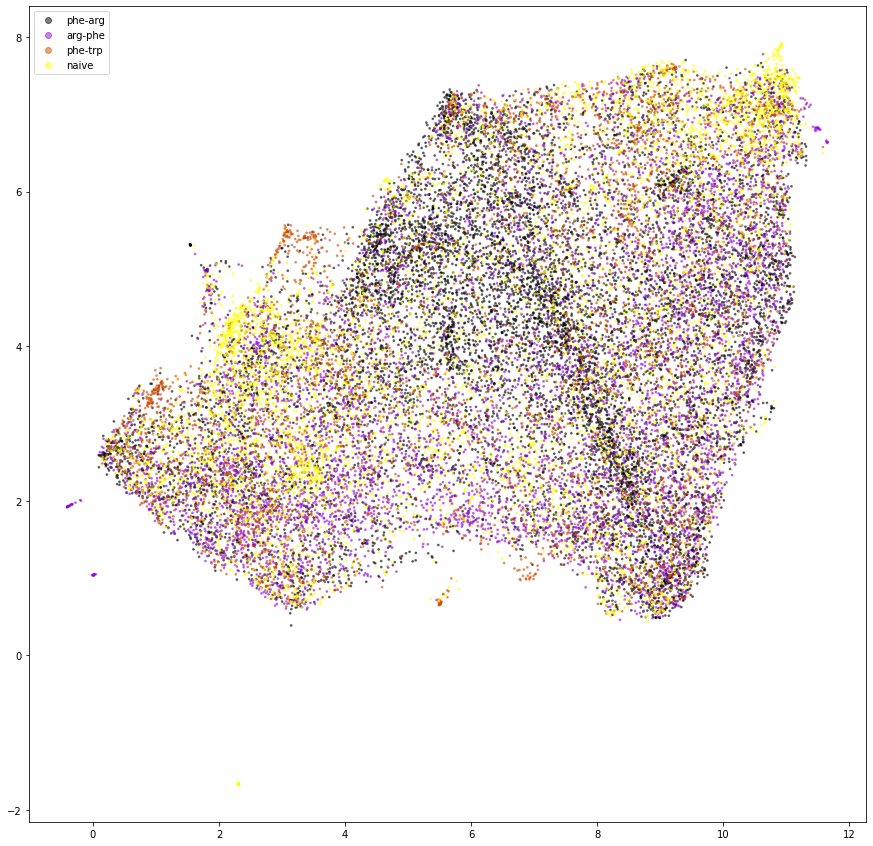

In [6]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(standard_embedding[:,0], standard_embedding[:,1], s=3, c=cond_idx, alpha=0.5, cmap='gnuplot')
ax.legend(handles=scatter.legend_elements()[0], labels=cond_list)

In [15]:
def plot_label_on_umap(labels, cmap='Spectral'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    clustered = (labels >= 0)
    plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.2,
            alpha=0.5)
    scatter = plt.scatter(standard_embedding[clustered, 0],
                standard_embedding[clustered, 1],
                c=labels[clustered],
                          
                s=0.5,
                cmap=cmap)
    plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1])
    return fig


In [4]:
import phenograph
import importlib
importlib.reload(phenograph)
k=100
communities, graph, Q = phenograph.cluster(clusterable_embedding, k=k)

NameError: name 'clusterable_embedding' is not defined

In [ ]:
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="day", style="time")

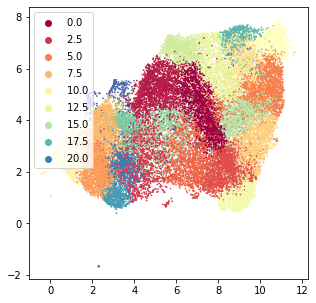

In [17]:
importlib.reload(catclust)
cmap = catclust.get_cluster_cmap(communities, cmap='Spectral')
fig = plot_label_on_umap(communities, cmap=cmap)
fig.set_size_inches((5,5))

In [10]:
import umap.plot
umap.plot.output_notebook()

Loading BokehJS ...

In [8]:
hover_data = pd.DataFrame({'label': communities})
pp = umap.plot.interactive(standard_fit, labels=communities, hover_data=hover_data, point_size=2)
umap.plot.show(pp)

NameError: name 'communities' is not defined

In [78]:
importlib.reload(catclust)
def get_cluster_mean_df(H, labels):
    clustdf = catclust.get_cluster_df(H, labels)
    cluster_mean_df = clustdf.groupby('cluster_id').mean()
    cluster_mean_df = pd.melt(cluster_mean_df, var_name='trial_key', value_name='response', ignore_index=False).reset_index()

    trial_list = list(cluster_mean_df.trial_key.unique())
    trial_ord = cluster_mean_df.trial_key.map(lambda x: trial_list.index(x))
    cluster_mean_df["trial"] = trial_ord
    cluster_mean_df = cluster_mean_df[cluster_mean_df.trial<18]
    return cluster_mean_df

In [82]:
def _get_odor_list(trial_list):
    odor_list = [key[0] for key in trial_list]
    odor_list = list(dict.fromkeys(odor_list))
    return odor_list

In [80]:
def plot_cluster_tuning(cluster_mean_df, cmap="tab20c"):
    # Initialize the FacetGrid object
    pal = sns.color_palette(cmap) #sns.cubehelix_palette(n_clusters, rot=-.25, light=.7)
    g = sns.FacetGrid(cluster_mean_df, row="cluster_id", hue="cluster_id", aspect=15, height=.5, palette=pal)
    # Draw the densities in a few steps
    g.map(sns.barplot, "trial", 'response')
    # passing color=None to refline() uses the hue mapping
    #g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .2, int(float(label)), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "trial")
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.05)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    n_trials = cluster_mean_df.trial.max()
    trial_per_odor = 3
    trial_list2 = list(cluster_mean_df.trial_key.unique())
    for ax in g.axes.flat:
        ax.set_xticks(np.arange(0, n_trials, trial_per_odor)) # <--- set the ticks first
        ax.set_xticklabels(_get_odor_list(trial_list2))
        # ax.set_xlabel('Trial')
        ax.set(xlabel=None)

/home/hubo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


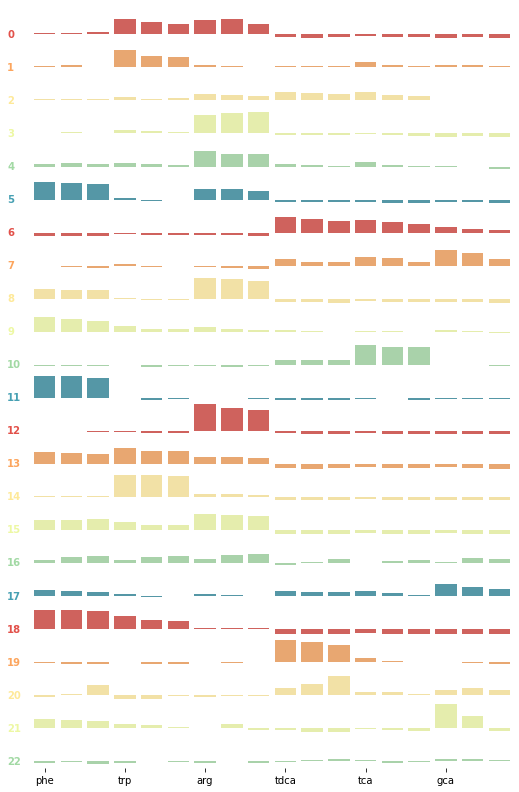

In [20]:
plot_cluster_tuning(cluster_mean_df, cmap="Spectral")

In [65]:
import json
odor_family_file = "/home/hubo/Projects/Ca_imaging/results/JH_analysis/umap_cluster_odor_family.json"
with open(odor_family_file) as f:
    odor_family_dict = json.load(f)

odor_family_dict = {int(k):v for k,v in odor_family_dict.items()}
odor_family_dict

{0: 'a.a.',
 1: 'a.a.',
 2: 'mix',
 3: 'a.a.',
 4: 'a.a.',
 5: 'a.a.',
 6: 'b.a.',
 7: 'b.a.',
 8: 'a.a.',
 9: 'a.a.',
 10: 'b.a.',
 11: 'a.a.',
 12: 'a.a.',
 13: 'a.a.',
 14: 'a.a.',
 15: 'a.a.',
 16: 'a.a.',
 17: 'mix',
 18: 'a.a.',
 19: 'b.a.',
 20: 'a.a.',
 21: 'mix',
 22: 'no response'}

In [84]:
def get_embed_df(embedding, labels):
    embed_df = pd.DataFrame(np.column_stack((embedding, labels)), columns=["umap1", "umap2", "cluster_id"])
    embed_df["cluster_id"] = embed_df["cluster_id"].astype(int)
    return embed_df

In [ ]:
#def get_embed_df(embedding, labels):
#    embed_df = pd.DataFrame(np.column_stack((embedding, communities)), columns=["umap1", "umap2", "cluster_id"])
#    embed_df["cluster_id"] = embed_df["cluster_id"].astype(int)
#    embed_df["tuned_odor_family"] = embed_df["cluster_id"].map(odor_family_dict)
#    return embed_df
embed_df["tuned_odor_family"] = embed_df["cluster_id"].map(odor_family_dict)
    

In [97]:
def plot_embed_df(embed_df, selector=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    if selector is None:
        data = embed_df
    else:
        data = embed_df[selector]
    if "tuned_odor_family" in embed_df:
        style = "tuned_odor_family"
    else:
        style = None   
    sns.scatterplot(ax=ax,
                    data=data,
                    x="umap1", y="umap2",
                    hue="cluster_id", style=style,
                    palette="Spectral", s=2)

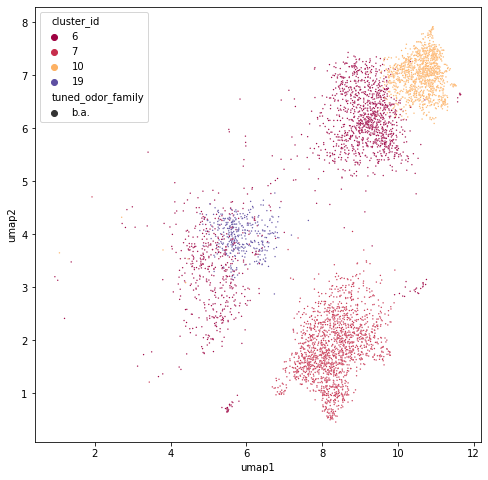

In [69]:
selector = embed_df["tuned_odor_family"]=="b.a."
plot_embed_df(embed_df, selector)

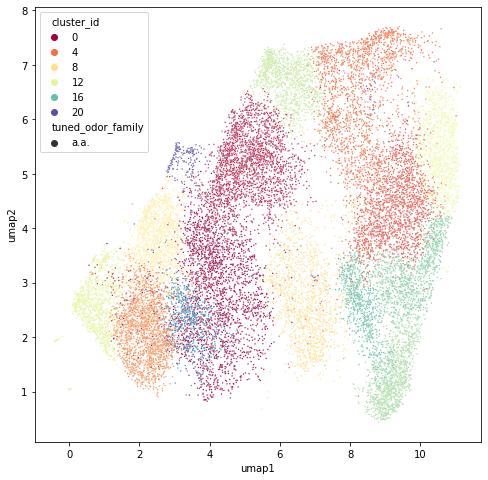

In [70]:
selector = embed_df["tuned_odor_family"]=="a.a."
plot_embed_df(embed_df, selector)

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

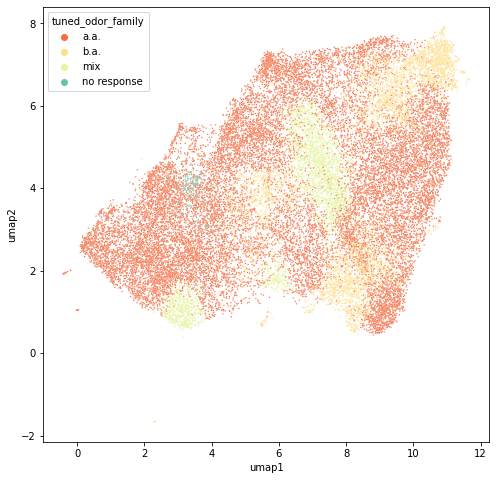

In [72]:

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(ax=ax,
                    data=embed_df,
                    x="umap1", y="umap2",
                    hue="tuned_odor_family",
                    palette="Spectral", s=2)

In [7]:
def plot_cluster_cont_with_stat(pairs):
    hue_plot_params = dict(x="cluster_id", y="ratio", hue="train_cond", hue_order=dtpar.cond_list,
                           data=cluster_count_df, palette="Set3")

    with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
        fig, ax = plt.subplots(figsize=(16,10))

    # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test="t-test_ind").apply_and_annotate()

    # Label and show
        legend = ax.legend()
        frame = legend.get_frame()
        frame.set_facecolor('white')
        ax.set_ylabel('#neurons in cluster/total #neurons')
    return annotator, fig

def get_significant_pairs(annotator):
    new_pairs = [[ano.data.group1, ano.data.group2] for ano in annotator.annotations if ano.data.pvalue < 0.05]
    return new_pairs

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5_arg-phe vs. 5_phe-trp: t-test independent samples, P_val:5.201e-01 t=-6.644e-01
6_arg-phe vs. 6_phe-trp: t-test independent samples, P_val:3.648e-01 t=-9.453e-01
7_arg-phe vs. 7_phe-trp: t-test independent samples, P_val:8.039e-01 t=-2.544e-01
8_arg-phe vs. 8_phe-trp: t-test independent samples, P_val:4.826e-01 t=7.266e-01
9_arg-phe vs. 9_phe-trp: t-test independent samples, P_val:5.834e-01 t=-5.650e-01
10_arg-phe vs. 10_phe-trp: t-test independent samples, P_val:2.202e-01 t=-1.300e+00
11_arg-phe vs. 11_phe-trp: t-test independent samples, P_val:9.326e-01 t=8.658e-02
12_arg-phe vs. 12_phe-trp: t-test independent samples, P_val:1.688e-01 t=-1.473e+00
13_arg-phe vs. 13_phe-trp: t-test independent samples, P_val:1.430e-02 t=-2.906e+00
14_arg-phe vs. 14_phe-trp: t-test independent samples, P_val:8.789e-02 t=-1

14_phe-arg vs. 14_naive: t-test independent samples, P_val:1.826e-01 t=-1.402e+00
15_phe-arg vs. 15_naive: t-test independent samples, P_val:9.281e-01 t=9.191e-02
16_phe-arg vs. 16_naive: t-test independent samples, P_val:5.419e-01 t=-6.242e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

13_arg-phe vs. 13_phe-trp: t-test independent samples, P_val:1.430e-02 t=-2.906e+00
0_phe-arg vs. 0_arg-phe: t-test independent samples, P_val:8.039e-03 t=-3.026e+00
2_arg-phe vs. 2_naive: t-test independent samples, P_val:7.146e-03 t=3.146e+00
1_arg-phe vs. 1_naive: t-test independent samples, P_val:4.006e-02 t=2.263e+00
9_arg-phe vs. 9_naive: t-test independent samples, P_val:3.346e-02 t=-2.358e+00
13_phe-arg vs. 13_phe-trp: t-test independent samples, P_val:3.705e-03 t=-3.529e+00
13_arg-phe vs. 13_naive: t-test independent samples, P_val:3.940e-02 t=-2.272e+00
9_ph

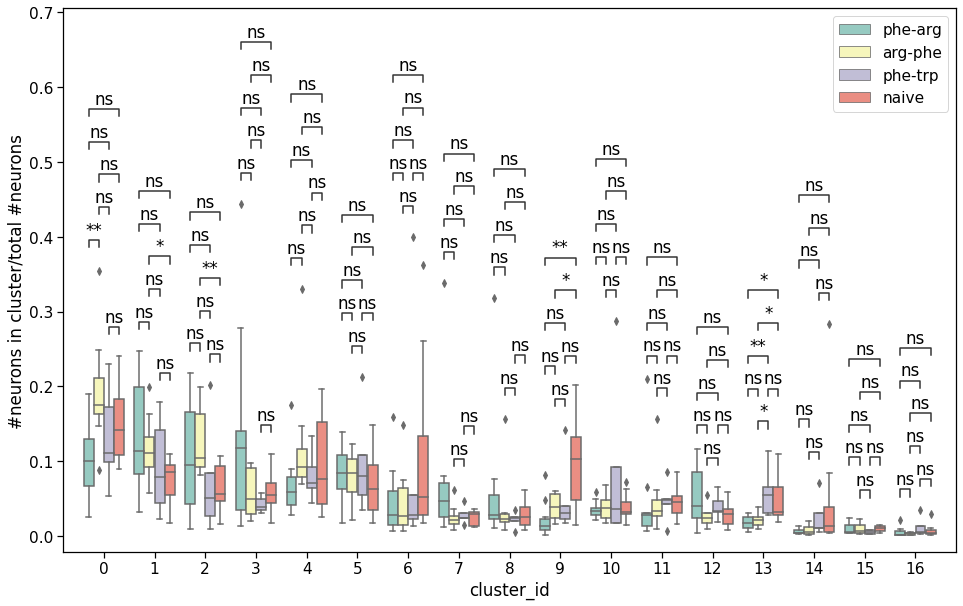

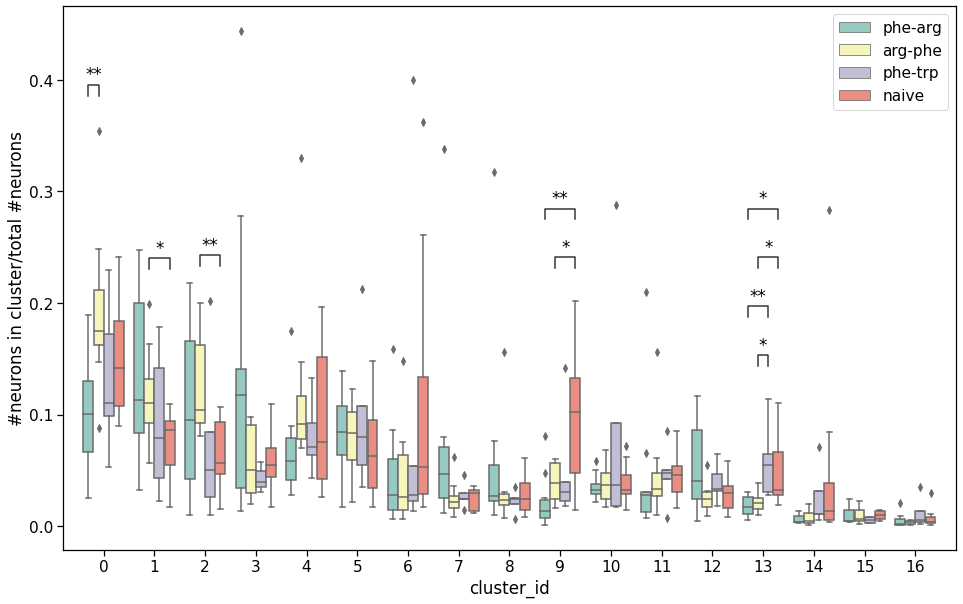

In [8]:
from statannotations.Annotator import Annotator
labels = communities_raw
n_clusters = len(np.unique(labels))
cluster_df = pd.DataFrame(labels.reshape(1,-1), columns=all_response.columns)
cluster_df = cluster_df.transpose().rename(columns={0:'cluster_id'}).reset_index()
training_dict = dict(dtpar.exp_list)
cluster_df['train_cond']= cluster_df['fish_id'].map(training_dict)
cluster_count_df = cluster_df.groupby('train_cond', sort=False).cluster_id.value_counts(normalize=True).sort_index().reindex(dtpar.cond_list, level='train_cond')
cluster_count_df
from itertools import combinations
cond_pair = list(combinations(dtpar.cond_list, 2))
all_pairs = []

for cluster_id in range(n_clusters):
    all_pairs.extend([[(cluster_id, x[0]), (cluster_id, x[1])] for x in cond_pair])
    
cluster_df = pd.DataFrame(labels.reshape(1,-1), columns=all_response.columns)
cluster_df = cluster_df.transpose().rename(columns={0:'cluster_id'}).reset_index()
training_dict = dict(exp_list)
cluster_df['train_cond']= cluster_df['fish_id'].map(training_dict)
cond_list = ['phe-arg', 'arg-phe', 'phe-trp', 'naive']

grouped_cluster_id = cluster_df.groupby(['fish_id','train_cond'], sort=False).cluster_id
cluster_count_df = grouped_cluster_id.value_counts(normalize=True).sort_index().reindex(cond_list, level='train_cond')

cluster_count_df = cluster_count_df.rename('ratio').reset_index()
cluster_count_df

annotator, fig1 = plot_cluster_cont_with_stat(all_pairs)

new_pairs = get_significant_pairs(annotator)
new_pairs

annotator2, fig2 = plot_cluster_cont_with_stat(new_pairs)

In [9]:
cluster_df

,fish_id,plane,neuron,cluster_id,train_cond
0,2021-02-05-DpOBEM-JH9,0,4,3,phe-arg
1,2021-02-05-DpOBEM-JH9,0,7,12,phe-arg
2,2021-02-05-DpOBEM-JH9,0,10,2,phe-arg
3,2021-02-05-DpOBEM-JH9,0,11,3,phe-arg
4,2021-02-05-DpOBEM-JH9,0,15,13,phe-arg
...,...,...,...,...,...
28309,2022-02-20-DpOBEM-N11,3,233,7,naive
28310,2022-02-20-DpOBEM-N11,3,234,3,naive
28311,2022-02-20-DpOBEM-N11,3,235,9,naive
28312,2022-02-20-DpOBEM-N11,3,236,11,naive


In [12]:
cluster_df.to_pickle('../../../results/JH_analysis/cluster_df_{}.pkl'.format(region))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_arg-phe vs. 7_phe-trp: t-test independent samples, P_val:2.888e-02 t=-2.512e+00
13_arg-phe vs. 13_phe-trp: t-test independent samples, P_val:4.106e-02 t=-2.313e+00
0_phe-arg vs. 0_arg-phe: t-test independent samples, P_val:1.034e-02 t=-2.905e+00
7_phe-arg vs. 7_phe-trp: t-test independent samples, P_val:2.358e-02 t=-2.564e+00
2_arg-phe vs. 2_naive: t-test independent samples, P_val:2.431e-03 t=3.689e+00
1_arg-phe vs. 1_naive: t-test independent samples, P_val:2.217e-02 t=2.572e+00
12_arg-phe vs. 12_naive: t-test independent samples, P_val:3.171e-02 t=-2.386e+00
13_phe-arg vs. 13_phe-trp: t-test independent samples, P_val:2.318e-02 t=-2.636e+00
12_phe-arg vs. 12_naive: t-test independent samples, P_val:4.803e-03 t=-3.271e+00


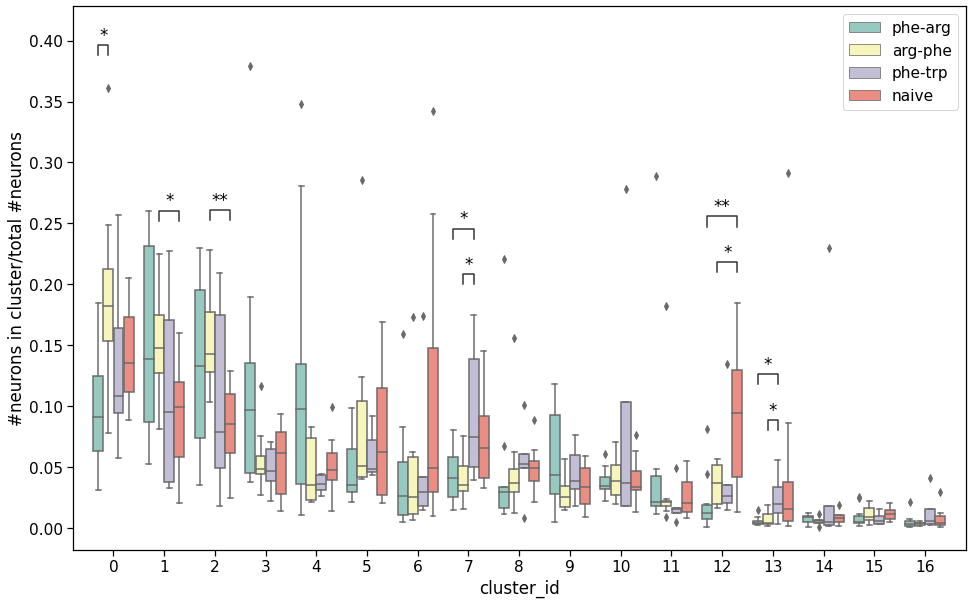

In [30]:
annotator2, fig = plot_cluster_cont_with_stat(new_pairs)
fig.savefig(os.path.join(fig_dir, "cluster_cont.svg"))

In [4]:
import phenograph
import importlib
importlib.reload(phenograph)
k=40
communities_raw, graph, Q = phenograph.cluster(data, k=k)

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm


/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Neighbors computed in 19.7751681804657 seconds
Jaccard graph constructed in 2.975252151489258 seconds
Wrote graph to binary file in 0.6307971477508545 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.745038
Louvain completed 21 runs in 24.910008907318115 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 48.600764751434326 seconds


In [5]:
data

odor                                     phe                           trp  \
trial                                      0         1         2         0   
fish_id               plane neuron                                           
2021-02-05-DpOBEM-JH9 0     4       0.190423  0.988375  0.026474  0.876671   
                            7      -1.437021  0.775026 -0.897835  1.737275   
                            10      0.988983  3.451545  0.830170 -0.855763   
                            11     -0.526571  0.169151  0.157899  0.664583   
                            15      2.036833  1.383438  1.523301  1.733576   
...                                      ...       ...       ...       ...   
2022-02-20-DpOBEM-N11 3     233     0.138150  0.545202 -0.187869  2.665215   
                            234     1.167292  0.813320 -0.044742  3.034821   
                            235     1.487088  0.713711  3.881366 -0.801968   
                            236     3.356525  1.416573  0.476767  0.462049   
                            237     0.311594  0.120851  0.378874 -0.269621   

odor                                                         arg            \
trial                                      1         2         0         1   
fish_id               plane neuron                                           
2021-02-05-DpOBEM-JH9 0     4       0.672470  0.988720 -1.285865 -0.203749   
                            7       2.491222 -0.442007  0.407090  0.062774   
                            10      0.007754 -0.593216  1.299586  0.897080   
                            11      2.366725  0.409864 -0.053287  0.681550   
                            15      1.110244  0.958387 -0.158354  0.389746   
...                                      ...       ...       ...       ...   
2022-02-20-DpOBEM-N11 3     233     2.304320  0.660435  1.474562  0.936408   
                            234    -0.435268 -0.174208  1.531337 -0.022602   
                            235     0.170115 -0.471541  0.080461 -0.331878   
                            236    -0.745119  0.490710  0.778457  0.066400   
                            237     0.251096 -0.290418  0.984345 -0.729315   

odor                                              tdca  ...       tca  \
trial                                      2         0  ...         2   
fish_id               plane neuron                      ...             
2021-02-05-DpOBEM-JH9 0     4      -0.357404  1.004938  ...  1.109173   
                            7      -0.362382  0.220593  ... -0.074153   
                            10      0.016230 -0.136990  ...  0.197374   
                            11     -0.235149 -0.390850  ...  1.068493   
                            15     -0.022174 -0.505378  ... -0.395862   
...                                      ...       ...  ...       ...   
2022-02-20-DpOBEM-N11 3     233     0.074849 -0.054560  ... -0.861586   
                            234     0.228186 -0.175568  ... -1.072714   
                            235    -0.679951 -0.230372  ... -0.330093   
                            236    -0.095431  0.200803  ... -0.027457   
                            237     1.706263  2.315425  ...  1.522316   

odor                                     gca                          acsf  \
trial                                      0         1         2         0   
fish_id               plane neuron                                           
2021-02-05-DpOBEM-JH9 0     4       0.081908  0.877112  0.455882 -1.357414   
                            7       0.237643  0.479515 -1.190153 -1.354593   
                            10     -0.876520 -0.407413 -0.233558 -0.988301   
                            11      0.100294  0.243607  0.662486  0.220514   
                            15     -0.213423  0.238290 -0.118075 -1.008187   
...                                      ...       ...       ...       ...   
2022-02-20-DpOBEM-N11 3     233     0.107405 -0.232651 -1.169550 -0.809584   
           

In [10]:
communities_raw.shape

(28314,)

/home/hubo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


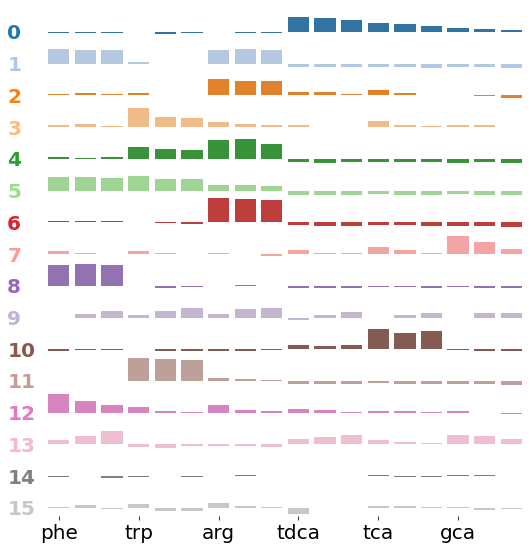

In [5]:
importlib.reload(catclust)
cluster_mean_df_raw = catclust.get_cluster_mean_df(H, communities_raw)
fig = catclust.plot_cluster_tuning(cluster_mean_df_raw, cmap="tab20")
fig_dir = "/home/hubo/Projects/Ca_imaging/results/JH_analysis/figures"
fig.savefig(os.path.join(fig_dir, "cluster_mean.svg"))

In [8]:
importlib.reload(catclust)
embed_df_nn = catclust.get_embed_df(standard_embedding, communities_raw)

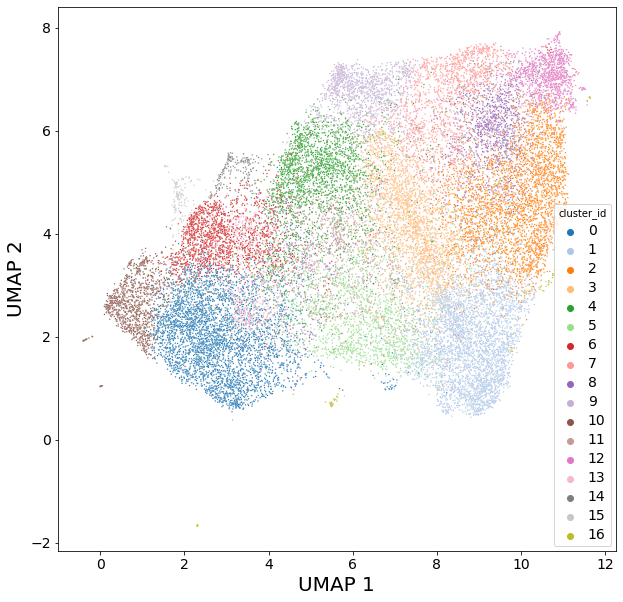

In [23]:
importlib.reload(catclust)
fig = catclust.plot_embed_df(embed_df_nn, cmap="tab20")
fig.savefig(os.path.join(fig_dir, "cluster_umap.svg"))
fig.savefig(os.path.join(fig_dir, "cluster_umap.png"))

In [34]:
cond_list

['phe-arg', 'arg-phe', 'phe-trp', 'naive']

In [41]:
def plot_cond_embedding(u, cond_idices, cond_idx):
    uu = u[cond_idices==cond_idx]
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(uu[:,0], uu[:,1], s=1)

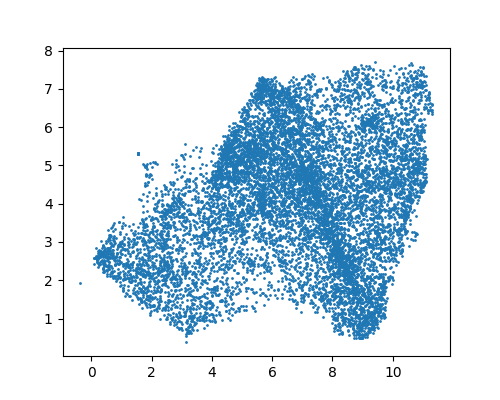

In [42]:
plot_cond_embedding(standard_embedding, cond_idx, 0)

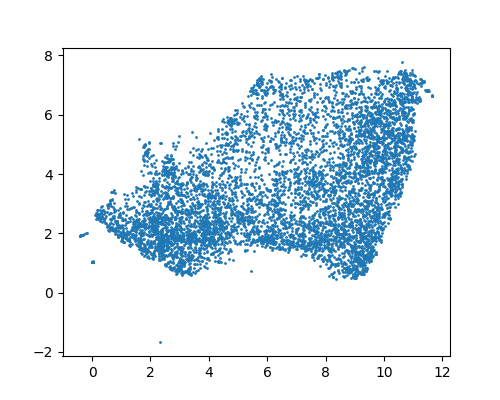

In [44]:
plot_cond_embedding(standard_embedding, cond_idx, 1)

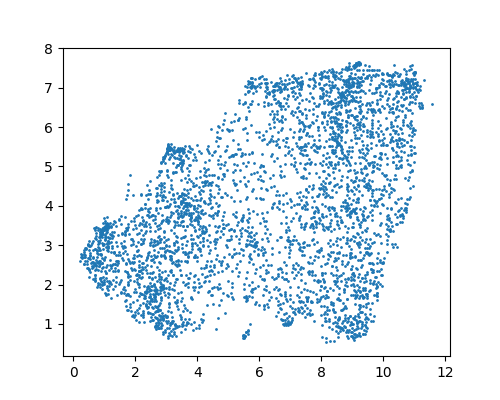

In [47]:
plot_cond_embedding(standard_embedding, cond_idx, 2)

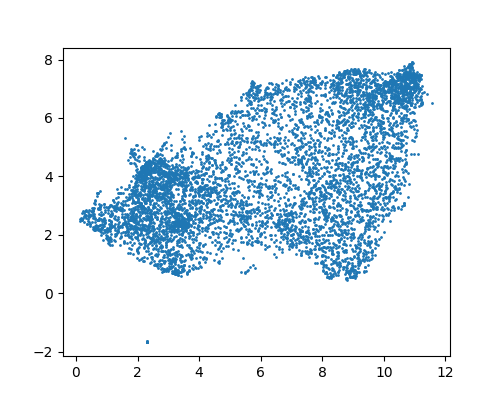

In [48]:
plot_cond_embedding(standard_embedding, cond_idx, 3)

In [120]:
region = 'Dp'
all_response = pd.read_pickle('../../../results/JH_analysis/all_response_select_{}.pkl'.format(region))
import catrace.scale as catscale
from sklearn.cluster import KMeans, AgglomerativeClustering
H = catscale.standard_scale(all_response)
data = H.transpose()
fish_id = data.index.get_level_values('fish_id')
training_dict = dict(dtpar.exp_list)
train_cond= fish_id.map(training_dict)
cond_list = ['phe-arg', 'arg-phe', 'phe-trp', 'naive']
cond_order = {k: v for v, k in enumerate(cond_list)}
cond_order
cond_idx = train_cond.map(cond_order)
fit = umap.UMAP(
        n_neighbors=200,
        min_dist=0.000001,random_state=42)
u = fit.fit_transform(data);

/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


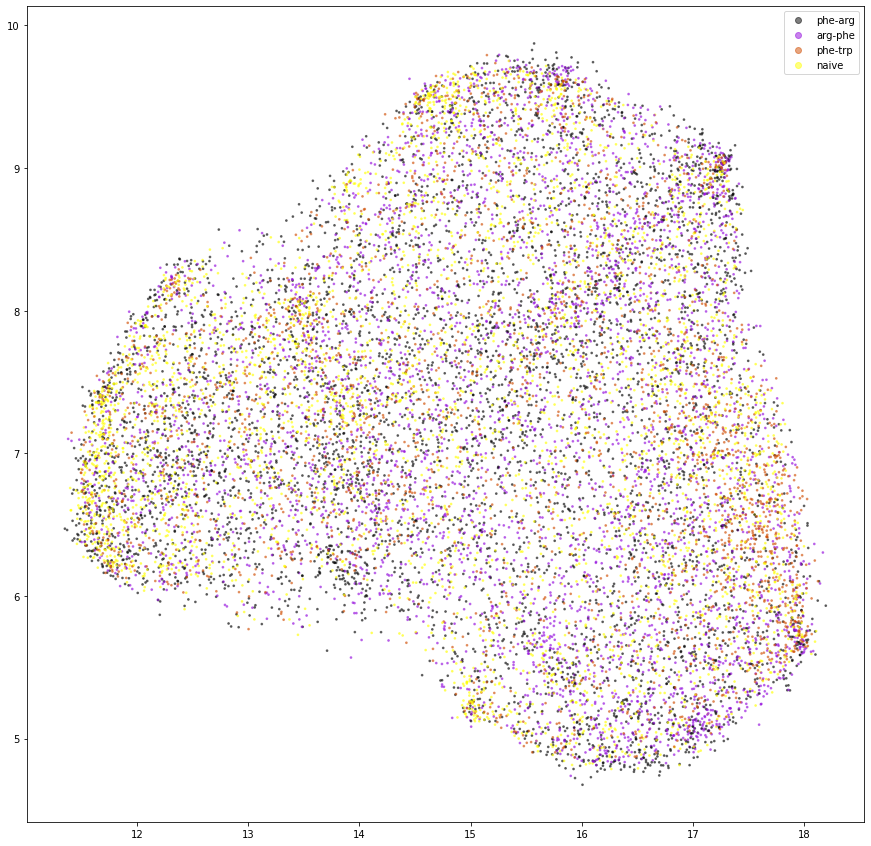

In [121]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(u[:,0], u[:,1], s=3, c=cond_idx, alpha=0.5, cmap='gnuplot')
ax.legend(handles=scatter.legend_elements()[0], labels=cond_list)